In [53]:
import numpy as np
import torch
import torch.nn.functional as F
import tiktoken
import logging
import json
from time import time
from safetensors import safe_open
from model import FlashSTU
from config import FlashSTUConfig
import torch.nn as nn

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


def get_hankel(seq_len: int, use_hankel_L: bool = False) -> np.ndarray:
    entries = np.arange(1, seq_len + 1, dtype=np.float64)
    i_plus_j = entries[:, None] + entries[None, :]

    if use_hankel_L:
        sgn = (-1.0) ** (i_plus_j - 2.0) + 1.0
        denom = (i_plus_j + 3.0) * (i_plus_j - 1.0) * (i_plus_j + 1.0)
        Z = sgn * (8.0 / denom)
    elif not use_hankel_L:
        Z = 2.0 / (i_plus_j**3 - i_plus_j)
    else:
        raise ValueError("use_hankel_L must be a boolean")

    return Z

def get_spectral_filters(
    seq_len: int, 
    K: int, 
    use_hankel_L: bool = False, 
    device: torch.device = None,
    dtype: torch.dtype = torch.bfloat16,
) -> torch.Tensor:
    assert torch.cuda.is_available(), "CUDA is required."
    Z = get_hankel(seq_len, use_hankel_L)
    sigma, phi = np.linalg.eigh(Z)
    sigma_k, phi_k = sigma[-K:], phi[:, -K:]
    phi_k *= sigma_k ** 0.25
    filters = torch.from_numpy(phi_k)
    return filters.to(device=device, dtype=dtype)

# Load the checkpoint
print("Loading the checkpoint...")
start_time = time()
state_dict = {}
with safe_open(
    "model_19073.safetensors",
    framework="pt",
    device="cuda",
) as f:
    for k in f.keys():
        state_dict[k] = f.get_tensor(k)

print(f"Successfully loaded the checkpoint in {time() - start_time:.2f} seconds")


Using device: cuda
Loading the checkpoint...
Successfully loaded the checkpoint in 0.87 seconds


In [54]:
# Set precision for matrix multiplication
torch.set_float32_matmul_precision("high")

# Load model configurations from JSON file
with open("config.json", "r") as file:
    config = json.load(file)

# Extract model configurations
n_embd = config["n_embd"]
n_heads = config["n_heads"]
n_layers = config["n_layers"]
seq_len = config["seq_len"]
window_size = config["window_size"]
vocab_size = config["vocab_size"]
mlp_scale = config["mlp_scale"]
bias = config["bias"]
dropout = config["dropout"]
num_eigh = config["num_eigh"]
use_hankel_L = config["use_hankel_L"]
use_flash_fft = config["use_flash_fft"]
use_approx = config["use_approx"]
use_attn = config["use_attn"]
softcap = config["softcap"]

# Model setup
config = FlashSTUConfig(
    n_embd=n_embd,
    n_heads=n_heads,
    n_layers=n_layers,
    seq_len=seq_len,
    window_size=window_size,
    vocab_size=vocab_size,
    mlp_scale=mlp_scale,
    bias=bias,
    dropout=dropout,
    num_eigh=num_eigh,
    use_hankel_L=use_hankel_L,
    use_flash_fft=use_flash_fft,
    use_approx=use_approx,
    use_attn=use_attn,
    softcap=softcap,
    torch_dtype=getattr(torch, config["torch_dtype"]),
)
phi = get_spectral_filters(seq_len, num_eigh, use_hankel_L, device, torch.float32)
model = FlashSTU(config, phi)

# Load state dictionary into the model
model.load_state_dict(state_dict, strict = True)
model.to(device)
model.eval()

# Prepare tokenizer
tokenizer = tiktoken.get_encoding("o200k_base")

Model Parameter Count: 426.28M



In [11]:
import tqdm
def generate_text(
    model, tokenizer, prompt, num_return_sequences=4, max_length=1024, device="cuda", temperature=1.0, top_k=50
):
    model.eval()
    tokens = torch.tensor([tokenizer.encode(prompt, allowed_special={"<|endoftext|>"})], device=device)
    tokens = tokens.repeat(num_return_sequences, 1)

    sample_rng = torch.Generator(device=device)
    sample_rng.manual_seed(1337)

    eos_token_id = tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"})[0]

    with torch.no_grad():
        for _ in tqdm.tqdm(range(max_length - tokens.size(1))):
            with torch.amp.autocast(device_type="cuda", dtype=torch.bfloat16):
                logits = model(tokens)
                logits = logits[:, -1, :]  # Get logits for the last token

                # Apply temperature scaling if temperature > 0
                if temperature > 0:
                    logits = logits / temperature

            probs = F.softmax(logits, dim=-1)  # Compute probabilities

            # Top-K sampling: set all probabilities outside the top K to 0
            top_k_probs, top_k_indices = torch.topk(probs, top_k, dim=-1)
            ix = torch.multinomial(top_k_probs, 1, generator=sample_rng)
            next_token = torch.gather(top_k_indices, -1, ix)
            tokens = torch.cat((tokens, next_token), dim=1)

            # Break if EOS token is generated
            if (next_token == eos_token_id).any():
                break

    generated_sequences = []
    for i in range(num_return_sequences):
        decoded = tokenizer.decode(tokens[i].tolist())
        generated_sequences.append(decoded)

    return generated_sequences

In [6]:
prompts = [
    "The future of artificial intelligence is",
    # "In the year 2050, the world will",
    # "The most important scientific discovery of the 21st century is",
    # "If I could change one thing about the education system, it would be",
    # "In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.",
]

for prompt in prompts:
    print(f"\nGenerating text for prompt: '{prompt}'\n")
    generated_texts = generate_text(model, tokenizer, prompt, num_return_sequences=1, max_length=50)
    for i, text in enumerate(generated_texts):
        print(f"Sample {i + 1}: {text}\n")



Generating text for prompt: 'The future of artificial intelligence is'



100%|██████████| 44/44 [00:06<00:00,  7.01it/s]

Sample 1: The future of artificial intelligence is also a bit controversial in the political area. The idea of artificial intelligence is actually a part of people who might not have a clear idea of how can we make this technology come to life. People that already have computers can



In [7]:
import copy
stu = copy.deepcopy(model.layers[0].stu)
stu.phi = stu.phi.to(torch.bfloat16)


In [6]:
# for i in range(0, n_layers, 2):
#     stu_layer = copy.deepcopy(model.layers[i].stu)
#     stu_layer.phi = stu_layer.phi.to(torch.bfloat16)
#     torch.save(stu_layer.state_dict(), f"./stu_layer_{i}_500m_param.pt")
#     torch.save(stu_layer, f"./stu_layer_{i}_500m_param_full.pt")

In [7]:
# # Load the full STU layer
# stu_layer_full = torch.load("./stu_layers/stu_layer_0_500m_param_full.pt")
# stu_layer_full.to(device)s

# # Prepare some input data
# inputs = torch.randn(5, 1024, 768).to(device).to(torch.bfloat16)

# # Run the STU layer
# outputs = stu_layer_full(inputs)
# print(outputs.shape)

In [8]:
# # Load the saved STU layer
# stu_larch.load("./stu_layer_0_500m_param.pt"))
# stu_layer.to(device)

# # Prepare some input data
# inputs = torch.randn(5, 1024, 768).to(device).to(torch.bfloat16)

# # Run the STU layer
# outputs = stu_layer(inputs)
# print(outputs.shape)

In [28]:
import copy
stu = copy.deepcopy(model.layers[0].stu)
stu.phi = stu.phi.to(torch.bfloat16)

AttributeError: 'LDS' object has no attribute 'phi'

In [5]:
inputs = torch.randn(1, 1024, 768).to(device).to(torch.bfloat16)
stu(inputs).shape

torch.Size([1, 1024, 768])

In [13]:
def exponential_decay_init(size, lam=5.0):
    """
    Samples from an exponential distribution with rate lam, 
    then clips at 1, does (1 - clipped_value),
    and finally multiplies by ±1 with probability 1/2.
    """
    # 1) Sample uniform [0,1], convert to exponential
    u = torch.rand(size)
    x = -1.0 / lam * torch.log(1 - u)  # Exponential(λ = lam)

    # 2) Clip at 1
    x = torch.clamp(x, max=1.0)

    # 3) Subtract from 1 (to be near 1 for small x)
    x = 1.0 - x  # Now we have distribution mostly near 1 for large lam

    # 4) Multiply by ±1 with prob 1/2
    sign = torch.sign(torch.randn(size))
    return x * sign

In [5]:
import matplotlib.pyplot as plt
plt.hist(exponential_decay_init(A.shape, lam = 15), bins =50)

NameError: name 'A' is not defined

In [6]:
import torch

def compute_ar_x_preds(w: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    """
    Compute the auto-regressive component of a spectral SSM (PyTorch version),
    allowing for a batch dimension in `x`.

    Args:
        w: A tensor of shape [d_out, d_in, k].
        x: A tensor of shape [batch_size, l, d_in].

    Returns:
        A tensor of shape [batch_size, l, d_out].
    """
    d_out, d_in, k = w.shape
    b, l, d_in_x = x.shape
    assert d_in == d_in_x, (
        f"Dimension mismatch: w.shape={w.shape}, x.shape={x.shape}"
    )

    o = torch.einsum("oik,bli->bklo", w, x)

    for i in range(k):
        # shape: [b, l, d_out]
        o[:, i] = torch.roll(o[:, i], shifts=i, dims=1)

    m = torch.triu(torch.ones(k, l, dtype=o.dtype, device=o.device))  # [k, l]
    # shape: [k, l, 1] -> then repeat along d_out
    m = m.unsqueeze(-1).repeat(1, 1, d_out)  # [k, l, d_out]

    ar_x_preds = torch.sum(o * m, dim=1)  # now shape is [b, l, d_out]

    return ar_x_preds


In [14]:
class LDS(nn.Module):
    def __init__(self, state_dim, input_dim, output_dim, kx=5):
        super(LDS, self).__init__()
        self.state_dim = state_dim
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.kx = kx
        self.h0 = nn.Parameter(torch.randn(state_dim))
        # init_A = torch.randn(state_dim)
        # self.A = nn.Parameter(init_A / torch.max(torch.abs(init_A)))

        # self.A = nn.Parameter((torch.rand(state_dim) * 0.2 + 0.8) * torch.sign(torch.randn(state_dim)))
        self.A = nn.Parameter(exponential_decay_init([state_dim], lam = 15))
        self.B = nn.Parameter(torch.randn(input_dim, state_dim) / input_dim)
        self.C = nn.Parameter(torch.randn(state_dim, output_dim) / state_dim)
        self.M = nn.Parameter(torch.randn(output_dim, input_dim, kx) / (output_dim))

    def forward(self, inputs):
        device = inputs.device
        bsz, seq_len, _ = inputs.shape
        h_t = self.h0.expand(bsz, self.state_dim).to(device)
        A = self.A.flatten()
        all_h_t = []
        for t in range(seq_len):
            u_t = inputs[:, t, :]
            h_t = A * h_t + (u_t @ self.B)
            all_h_t.append(h_t.unsqueeze(1))
        all_h_t = torch.cat(all_h_t, dim=1)
        lds_out = torch.matmul(all_h_t, self.C)

        ar = compute_ar_x_preds(self.M, inputs)
        return lds_out + ar

    def compute_loss(self, inputs, targets):
        mse_loss = nn.MSELoss()
        outputs = self(inputs)
        return mse_loss(outputs, targets)

In [45]:
import math
class LDS_LR(nn.Module):
    def __init__(self, state_dim, input_dim, output_dim, kx=5, rank = 50):
        super(LDS_LR, self).__init__()
        self.state_dim = state_dim
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.kx = kx
        self.h0 = nn.Parameter(torch.randn(state_dim))
        # init_A = torch.randn(state_dim)
        # self.A = nn.Parameter(init_A / torch.max(torch.abs(init_A)))

        self.A = nn.Parameter(exponential_decay_init([state_dim], lam = 15))
        self.B1 = nn.Parameter(torch.randn(input_dim, rank) / (input_dim))
        self.B2 = nn.Parameter(torch.randn(rank, state_dim) / (rank))
        self.C1 = nn.Parameter(torch.randn(state_dim, rank) / (state_dim))
        self.C2 = nn.Parameter(torch.randn(rank, output_dim) / (rank))
        self.M = nn.Parameter(torch.randn(output_dim, input_dim, kx) / (output_dim))


        # self.M1 = nn.Parameter(torch.randn(rank, input_dim, kx) / math.sqrt(output_dim))
        # self.M2 = nn.Parameter(torch.randn(output_dim, rank, kx) / math.sqrt(output_dim))

    def forward(self, inputs):
        device = inputs.devic
        bsz, seq_len, _ = inputs.shape
        h_t = self.h0.expand(bsz, self.state_dim).to(device)
        A = self.A.flatten()
        all_h_t = []

        lds_in = torch.matmul(inputs, self.B1)
        lds_in = torch.matmul(lds_in, self.B2)

        for t in range(seq_len):
            h_t = A * h_t + lds_in[:, t, :]
            all_h_t.append(h_t.unsqueeze(1))
        all_h_t = torch.cat(all_h_t, dim=1)
 
        lds_out = torch.matmul(all_h_t, self.C1)
        lds_out = torch.matmul(lds_out, self.C2)

        ar = compute_ar_x_preds(self.M, inputs)

        # ar = compute_ar_x_preds(self.M1, inputs)
        # ar = comspute_ar_x_preds(self.M2, ar)
        
        return lds_out + ar

    def compute_loss(self, inputs, targets):
        mse_loss = nn.MSELoss()
        outputs = self(inputs)
        return mse_loss(outputs, targets)


In [39]:
inputs = torch.randn(5, 4096, 768).to(device).to(torch.float)
bsz, seq_len, _ = inputs.shape
h_t = lds.h0.expand(bsz, lds.state_dim).to(device)
A = lds.A.flatten()
all_h_t = []

lds_in = torch.matmul(inputs, lds.B1)
lds_in = torch.matmul(lds_in, lds.B2)

for t in range(seq_len):
    h_t = A * h_t + lds_in[:, t, :]
    all_h_t.append(h_t.unsqueeze(1))
all_h_t = torch.cat(all_h_t, dim=1)

lds_out = torch.matmul(all_h_t, lds.C1)
lds_out = torch.matmul(lds_out, lds.C2)

ar = compute_ar_x_preds(lds.M1, inputs)
ar = compute_ar_x_preds(lds.M2, ar)

In [ ]:
#remarkably, the approximation gets better and better as state_dim increases from  20 to ~500 (i.e 500 is 8x better than 50)
state_dim = 100 #@param
lds = LDS(state_dim, 768, 768, kx = 5).to(device)
optimizer = torch.optim.Adam(lds.parameters(), lr = 0.002)
lds_epochs = 3001
lds_loss_values = []

for epoch in range(lds_epochs):
    inputs = torch.randn(5, 4096, 768).to(device).to(torch.bfloat16)
    stu_outputs = stu(inputs).to(device)

    optimizer.zero_grad()
    loss = lds.compute_loss(inputs.to(stu_outputs.dtype), stu_outputs)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(lds.parameters(), max_norm=1)
    lds_loss_values.append(loss.item())
    optimizer.step()

    with torch.no_grad():
        lds.A.data.clamp_(max=1, min = -1)

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}') #Epoch 2000, Loss: 0.00030023115687072277 for normal LDS and  state dim  10000
        #Epoch 2000, Loss: 0.001 for normal LDS and  state dim  1000
        #0.0007 for 2000 epochs on LDS with 5 autoregressive heads

        #with improved init we reach 0.00029 in 300 epochs at kx = 5
        #with improved init we reach 0.00027 in 300 epochs (range 0.7 - 1) at kx =5
        #with improved init we reached 0.00024 in 300 with range (0.8 - 1) at kx = 5
        #but worse perf for (0.9 - 1) at kx = 10
        #0.00020 with lam = 15

RuntimeError: expected mat1 and mat2 to have the same dtype, but got: float != struct c10::BFloat16

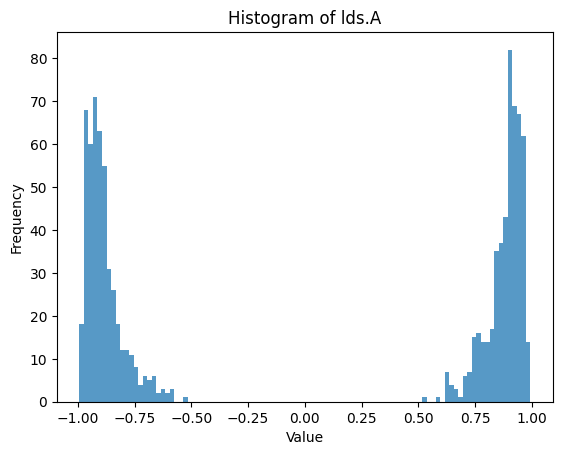

In [24]:
import matplotlib.pyplot as plt

# Convert lds.A to a numpy array and plot the histogram
A_data = lds.A.data.cpu().numpy()
plt.hist(A_data, bins=100, alpha=0.75)
plt.title('Histogram of lds.A')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [61]:
(torch.abs(stu_outputs - stu_outputs.mean())).mean()

tensor(0.2162, device='cuda:0', grad_fn=<MeanBackward0>)

In [ ]:
torch.save(lds.state_dict(), "./lds_layer_new_2cap_0.pt")

In [47]:
# Load the model and optimizer
checkpoint = torch.load("./lds_trained/9496_0_10000_0.00002_lds_model_and_optimizer.pt")
del checkpoint['lds_state_dict']['M'] #this param doesn't correspond to current M
lds_model = LDS(state_dim=10000, input_dim=768, output_dim=768, kx=0)
lds_model.load_state_dict(checkpoint['lds_state_dict'], strict =  False)

# Compute Cdiag(A)^iB for i in range(0, 10)
C = lds_model.C
A = lds_model.A
B = lds_model.B



M = torch.zeros((768, 768, 10), device=device)
low_order_A = A.clone()
low_order_A[(low_order_A > 0.7) | (low_order_A < -0.7)] = 0

for i in range(10): #encompases low order terms or so
    M[:, :, i] = (C.T  @ (B * low_order_A).T)

# Create a new LDS with kx = 10 and M initialized to these values
new_lds = LDS(state_dim=80000, input_dim=768, output_dim=768, kx=10)
new_lds.M.data = M

# Set all terms with low magnitude in A to 0
threshold = 0.7  # Define a threshold for low magnitude
A_new  = A.detach().clone()
A_new[torch.abs(A_new) < threshold] = 0
new_lds.A.data = A_new

new_lds.B.data = B.clone()
new_lds.C.data = C.clone()
print("New LDS model created and initialized.")

C:\Users\devan\AppData\Local\Temp\ipykernel_3020\743698104.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("./lds_trained/9496_0_10000_0.00002_ld

New LDS model created and initialized.


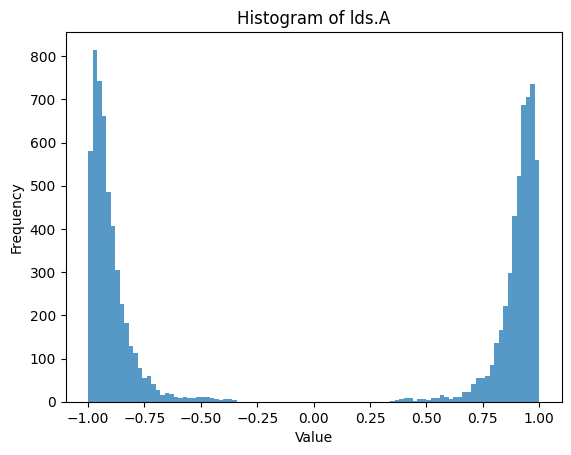

In [48]:
import matplotlib.pyplot as plt
A_data = lds_model.A.data.cpu().numpy()
plt.hist(A_data, bins=100, alpha=0.75)
plt.title('Histogram of lds.A')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [49]:
# Create a new LDS with kx = 10
new_lds_kx10 = LDS(state_dim=lds_model.state_dim, input_dim=lds_model.input_dim, output_dim=lds_model.output_dim, kx=50).to(device)

# Copy parameters from the original LDS model
new_lds_kx10.h0.data = lds_model.h0.data.clone()
new_lds_kx10.B.data = lds_model.B.data.clone()
new_lds_kx10.C.data = lds_model.C.data.clone()

# Move low-order diagonal terms to the matrix connections
low_order_A = lds_model.A.clone()
low_order_A[(low_order_A > 0.7) | (low_order_A < -0.7)] = 0

M = torch.zeros(new_lds_kx10.M.shape)
for i in range(50):  # Encompasses low order terms or so
    M[:, :, i] = (new_lds_kx10.C.T @ (new_lds_kx10.B * low_order_A).T)

new_lds_kx10.M.data = M
# Set all terms with low magnitude in A to 0
threshold = 0.7  # Define a threshold for low magnitude
A_new = lds_model.A.detach().clone()
A_new[torch.abs(A_new) < threshold] = 0
new_lds_kx10.A.data = torch.zeros(A_new.shape)

lds_model.A.data = low_order_A.clone()

print("New LDS model with kx=10 created and initialized.")

New LDS model with kx=10 created and initialized.


In [50]:
# Prepare some input data
inputs = torch.randn(1, 1024, 768).to(device).to(torch.float)

# Run the input through new_lds_kx10
new_lds_kx10.to(device).eval()
with torch.no_grad():
    new_lds_kx10_outputs = new_lds_kx10(inputs)

# Run the input through lds_model
lds_model.to(device).eval()
with torch.no_grad():
    lds_model_outputs = lds_model(inputs)

# Compare the outputs
print("Outputs from new_lds_kx10:")
print(new_lds_kx10_outputs)

print("\nOutputs from lds_model:")
print(lds_model_outputs)

# Check if the outputs are similar
similarity = torch.abs(new_lds_kx10_outputs - lds_model_outputs).mean()
print(f"\nAre the outputs similar? {similarity}")

#I don't know what the issue is, perhaps the problem is h0 being non-zero? So test with h0 = 0 for both models and see if that works better

Outputs from new_lds_kx10:
tensor([[[ 0.1239, -0.0006,  0.0172,  ..., -0.0154,  0.0364, -0.0091],
         [-0.0012,  0.0016,  0.0083,  ...,  0.0222, -0.1528,  0.0819],
         [-0.0658,  0.0404,  0.0418,  ...,  0.0120,  0.2279,  0.0225],
         ...,
         [-0.0991, -0.1607,  0.0120,  ...,  0.0182, -0.2866, -0.0342],
         [-0.0183, -0.1975,  0.0159,  ...,  0.0319, -0.1280, -0.0635],
         [-0.0708, -0.1178,  0.0105,  ...,  0.0152, -0.1076, -0.0723]]],
       device='cuda:0')

Outputs from lds_model:
tensor([[[ 1.4804e-01, -1.3836e-02,  1.2729e-02,  ..., -2.9600e-02,
           8.2252e-02,  2.5816e-03],
         [-1.1196e-02, -3.4558e-03,  8.7294e-03,  ...,  1.6984e-02,
          -1.3149e-01,  7.6630e-02],
         [-3.2758e-02,  1.9313e-02,  4.3930e-02,  ..., -1.0055e-03,
           3.1026e-01,  5.4414e-03],
         ...,
         [-5.1858e-02,  1.6662e-02,  1.3790e-02,  ...,  1.6665e-02,
          -2.4579e-01,  1.3395e-02],
         [ 1.3173e-02, -4.1623e-02,  1.6496e-02,

In [112]:
# Find indices where lds.A is not zero
non_zero_indices = (new_lds.A != 0).nonzero(as_tuple=True)[0]

# Filter B and C based on non-zero indices
B_filtered = new_lds.B[:, non_zero_indices].clone()
C_filtered = new_lds.C[non_zero_indices, :].clone()

# Create a new LDS with the filtered B and C
filtered_state_dim = len(non_zero_indices)
new_lds_filtered = LDS(filtered_state_dim, new_lds.input_dim, new_lds.output_dim, kx=new_lds.kx).to(device)
new_lds_filtered.B.data = B_filtered
new_lds_filtered.C.data = C_filtered
new_lds_filtered.A.data = new_lds.A[non_zero_indices].clone()

print("Filtered LDS model created and initialized.")
filtered_state_dim

Filtered LDS model created and initialized.


1041

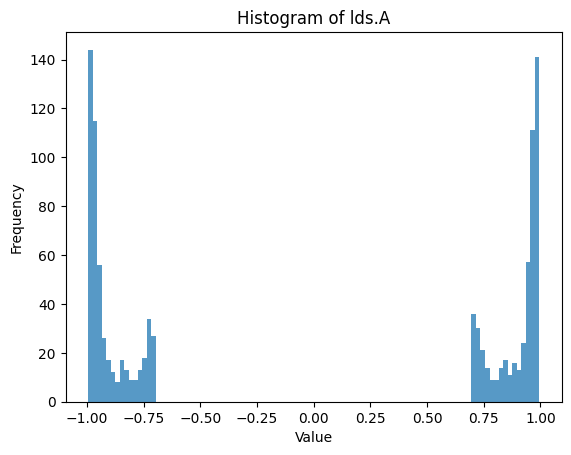

In [113]:
import matplotlib.pyplot as plt

# Convert lds.A to a numpy array and plot the histogram
A_data = new_lds_filtered.A.data.cpu().numpy()
plt.hist(A_data, bins=100, alpha=0.75)
plt.title('Histogram of lds.A')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [37]:
percent_over_0_9 = np.sum(A_data > 0.9) / len(A_data) * 100
print(f"Percentage of values over 0.9: {percent_over_0_9:.2f}%")

Percentage of values over 0.9: 33.74%


In [29]:
stu = copy.deepcopy(model.layers[0].stu)
stu.phi = stu.phi.to(torch.bfloat16)

optimizer = torch.optim.Adam(new_lds_filtered.parameters(), lr = 0.0001)
lds_epochs = 2001
lds_loss_values = []

for epoch in range(lds_epochs):
    inputs = torch.randn(5, 4096, 768).to(device).to(torch.bfloat16)
    stu_outputs = stu(inputs).to(device)

    optimizer.zero_grad()
    loss = new_lds_filtered.compute_loss(inputs.to(stu_outputs.dtype), stu_outputs)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(new_lds_filtered.parameters(), max_norm=1)
    lds_loss_values.append(loss.item())
    optimizer.step()

    with torch.no_grad():
        new_lds_filtered.A.data.clamp_(max=1, min = -1)

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

AttributeError: 'LDS' object has no attribute 'phi'

In [24]:
from dataloader import DataLoader

val_loader = DataLoader(
    bsz=1,
    seq_len=seq_len, 
    dataset='./fineweb-edu', 
    split="val", 
    main_process=True,
)

2025-01-12 23:09:10,521 - INFO - Found 1 shards for split val


In [25]:
from torch.amp import autocast
from torch.nn import CrossEntropyLoss

def evaluate(model):
    loss_fn = CrossEntropyLoss()
    val_loss = 0.0
    torch_dtype = getattr(torch, 'bfloat16')
    val_steps = 5 # Arbitrarily set to reduce long evaluations, >20 typically used
    model.eval()
    val_loader.reset()
    with torch.no_grad():
        for i, batch in zip(range(val_steps), val_loader, strict=False):
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)
            if torch_dtype != torch.float32:
                with autocast(device_type=device.type, dtype=torch_dtype, cache_enabled=True):
                    preds = model(inputs)
            else:
                preds = model(inputs)

            loss = loss_fn(preds.flatten(0, 1), targets.flatten(0, 1))
            loss = loss / val_steps
            val_loss += loss.detach().float()
    return(val_loss)

In [55]:
stu = copy.deepcopy(model.layers[0].stu)
model.layers[0].stu = lds_model.to(device)
evaluate(model)

#FOR SOME REASON, THE NEW LDS underperforms

tensor(7.8516, device='cuda:0')

In [57]:
import torch.nn as nn

# Generate random input
random_input = torch.randn(1, 1024, 768).to(device).to(torch.bfloat16)

# Compute outputs from stu and lds_model
stu.phi = stu.phi.to(torch.bfloat16)
stu_output = stu(random_input)
lds_model_output = lds_model(random_input.to(torch.float))

# Compute MSE loss
mse_loss_fn = nn.MSELoss()
mse_loss = mse_loss_fn(stu_output, lds_model_output)

print(f"MSE Loss: {mse_loss.item()}")

MSE Loss: 0.07866311073303223


In [27]:
new_lds.A

Parameter containing:
tensor([0., 0., 0.,  ..., 0., 0., 0.], requires_grad=True)

In [28]:
stu = copy.deepcopy(model.layers[0].stu)
model.layers[0].stu = new_lds.to(device) #filtered, slow
evaluate(model)

#FOR SOME REASON, THE NEW LDS underperforms

tensor(5.2266, device='cuda:0')

In [115]:
stu = copy.deepcopy(model.layers[0].stu)
model.layers[0].stu = new_lds_filtered.to(device) #filtered, fast
evaluate(model)

#FOR SOME REASON, THE NEW LDS underperforms

tensor(9.6250, device='cuda:0')

In [44]:
inputs = inputs.to(torch.float)

In [47]:
inputs.shape

torch.Size([1, 1024, 768])

In [95]:
new_lds_filtered = new_lds_filtered.to(device)

In [100]:
h_t = new_lds_filtered.h0.expand(1, new_lds_filtered.state_dim).to(device)
A = new_lds_filtered.A.flatten()
all_h_t = []
for t in range(1024):
    u_t = inputs[:, t, :]
    h_t = A * h_t + (u_t @ new_lds_filtered.B)
    all_h_t.append(h_t.unsqueeze(1))
all_h_t = torch.cat(all_h_t, dim=1)
lds_out = torch.matmul(all_h_t, new_lds_filtered.C)
new_ht = lds_out.clone()

In [109]:
new_ht + compute_ar_x_preds(new_lds_filtered.M,inputs)

tensor([[[-0.0559, -0.0489, -0.0393,  ..., -0.0129, -0.0298, -0.0301],
         [ 0.0111,  0.1352, -0.0287,  ..., -0.1449,  0.0984, -0.0868],
         [ 0.0075, -0.2174, -0.0297,  ...,  0.1494,  0.1317,  0.0024],
         ...,
         [-0.1460,  0.0488, -0.2218,  ..., -0.0125, -0.1097,  0.1176],
         [-0.1231,  0.0952,  0.0334,  ..., -0.0448, -0.0257, -0.0463],
         [-0.1197,  0.0074,  0.1675,  ..., -0.1491, -0.0926, -0.1805]]],
       device='cuda:0', grad_fn=<AddBackward0>)

In [106]:
lds_model= lds_model.to(device)

In [107]:
h_t = lds_model.h0.expand(1, lds_model.state_dim).to(device)
A = lds_model.A.flatten()
all_h_t = []
for t in range(1024):
    u_t = inputs[:, t, :]
    h_t = A * h_t + (u_t @ lds_model.B)
    all_h_t.append(h_t.unsqueeze(1))
all_h_t = torch.cat(all_h_t, dim=1)
lds_out = torch.matmul(all_h_t, lds_model.C)

In [104]:
lds_out

tensor([[[ 0.0369, -0.1756, -0.0140,  ..., -0.0095,  0.2034,  0.2664],
         [-0.0109, -0.1869, -0.1448,  ..., -0.0877, -0.2060, -0.1952],
         [-0.3321,  0.3115, -0.0473,  ..., -0.2979, -0.5652, -0.3678],
         ...,
         [-0.0103, -0.1460,  0.1361,  ..., -0.0476, -0.1077, -0.1046],
         [-0.0336, -0.2587,  0.1905,  ...,  0.1077, -0.0199, -0.0399],
         [ 0.1209, -0.1252, -0.2284,  ..., -0.1752, -0.1115,  0.1808]]],
       device='cuda:0', grad_fn=<UnsafeViewBackward0>)

In [ ]:
# can we remove D
# finetune model after residual
# factorization
# is gaussian most realistic input data (uniform?, from data)
# greedy fitting

#why does an LDS exist that fits the STU
#why does gradient descent find it

#stu filters are 24 dim subspace of R^L, this subclass captures LDSs,
#  

In [31]:
sorted(lds.A.data)[:5]

[tensor(-0.9963, device='cuda:0'),
 tensor(-0.9950, device='cuda:0'),
 tensor(-0.9950, device='cuda:0'),
 tensor(-0.9949, device='cuda:0'),
 tensor(-0.9948, device='cuda:0')]

In [32]:
sorted(lds.A.data)[-5:]

[tensor(0.9945, device='cuda:0'),
 tensor(0.9948, device='cuda:0'),
 tensor(0.9958, device='cuda:0'),
 tensor(0.9960, device='cuda:0'),
 tensor(0.9960, device='cuda:0')]

In [ ]:
# Load LDS models for layers 0, 2, and 4

lds_layer_0 = LDS(10000, 768, 768).to(device)
lds_layer_0.load_state_dict(torch.load("./lds_layer_0.pt"))

lds_layer_2 = LDS(10000, 768, 768).to(device)
lds_layer_2.load_state_dict(torch.load("./lds_layer_2.pt"))

lds_layer_4 = LDS(10000, 768, 768).to(device)
lds_layer_4.load_state_dict(torch.load("./lds_layer_4.pt"))

# Substitute LDS models into model2
model2.layers[0].stu = lds_layer_0
model2.layers[2].stu = lds_layer_2
model2.layers[4].stu = lds_layer_4

# Run evaluation
val_loss = evaluate(model2)
print(f"Validation Loss: {val_loss}")

C:\Users\devan\AppData\Local\Temp\ipykernel_21096\3432883371.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lds_layer_0.load_state_dict(torch.load("./lds_layer_0.pt"))


Validation Loss: 6.224609375


In [29]:
model2 =  copy.deepcopy(model)
model2.layers[0].stu = lds_layer_0
# model2.layers[2].stu = lds_layer_2
model2.layers[4].stu = lds_layer_4
val_loss = evaluate(model2)
print(f"Validation Loss: {val_loss}")

Validation Loss: 4.3359375


In [23]:
evaluate(model)

tensor(3.8779, device='cuda:0')

In [24]:
model

FlashSTU(
  (tok_emb): Embedding(200064, 768)
  (dropout): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0): STULayer(
      (stu_norm): RMSNorm((768,), eps=None, elementwise_affine=True)
      (stu): STU()
      (mlp_norm): RMSNorm((768,), eps=None, elementwise_affine=True)
      (mlp): MLP(
        (gate_proj): Linear(in_features=768, out_features=9216, bias=False)
        (up_proj): Linear(in_features=768, out_features=9216, bias=False)
        (down_proj): Linear(in_features=9216, out_features=768, bias=False)
        (dropout): Dropout(p=0.0, inplace=False)
      )
    )
    (1): AttentionLayer(
      (attn_norm): RMSNorm((768,), eps=None, elementwise_affine=True)
      (attn): Attention(
        (c_attn): Linear(in_features=768, out_features=2304, bias=False)
        (c_proj): Linear(in_features=768, out_features=768, bias=False)
        (resid_dropout): Dropout(p=0.0, inplace=False)
      )
      (mlp_norm): RMSNorm((768,), eps=None, elementwise_affine=True)
      (

In [25]:
model.layers[4].stu = stu

In [26]:
model

FlashSTU(
  (tok_emb): Embedding(200064, 768)
  (dropout): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0): STULayer(
      (stu_norm): RMSNorm((768,), eps=None, elementwise_affine=True)
      (stu): STU()
      (mlp_norm): RMSNorm((768,), eps=None, elementwise_affine=True)
      (mlp): MLP(
        (gate_proj): Linear(in_features=768, out_features=9216, bias=False)
        (up_proj): Linear(in_features=768, out_features=9216, bias=False)
        (down_proj): Linear(in_features=9216, out_features=768, bias=False)
        (dropout): Dropout(p=0.0, inplace=False)
      )
    )
    (1): AttentionLayer(
      (attn_norm): RMSNorm((768,), eps=None, elementwise_affine=True)
      (attn): Attention(
        (c_attn): Linear(in_features=768, out_features=2304, bias=False)
        (c_proj): Linear(in_features=768, out_features=768, bias=False)
        (resid_dropout): Dropout(p=0.0, inplace=False)
      )
      (mlp_norm): RMSNorm((768,), eps=None, elementwise_affine=True)
      (